# Figure Mrbles Beads

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import os
import sys
sys.path.append("../") # needed to bring in sdc module
import sdc_config5 as sdc
import sdc_config3 as sdc_np
import jax.numpy as jnp
import jax
# figures helper functions
%run figures_util.py
# from cleanplots import *

## Helper functions

<Figure size 600x300 with 0 Axes>

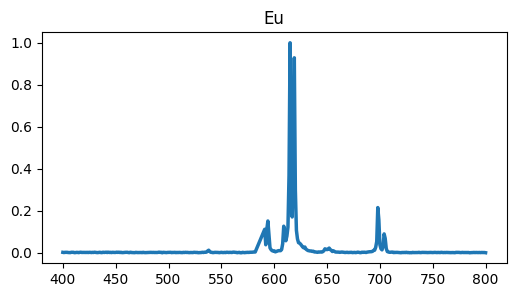

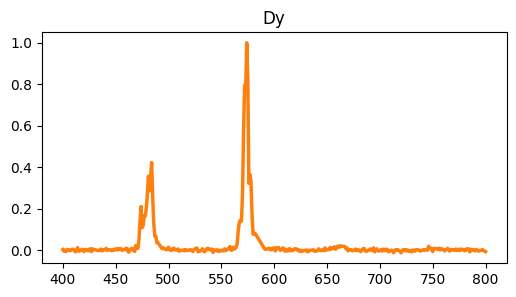

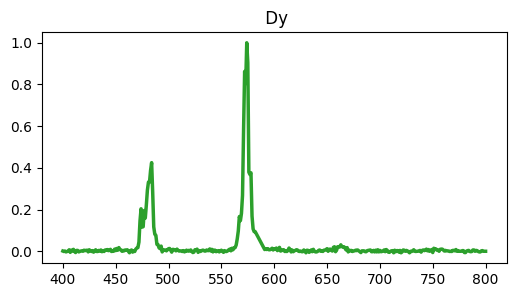

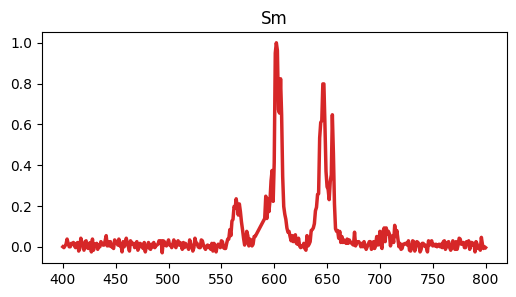

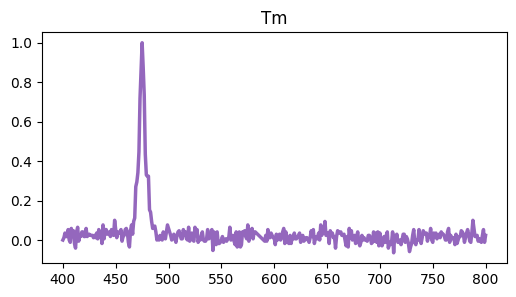

In [113]:
import numpy as np

# Draw boxes around the centroids and label bead number
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
rgb_colors = [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for color in colors]

# plot the ground truth spectra
# Specify the file path of the CSV file
file_path = "mrbles_spectra_20230412.csv"
# Read the CSV file into a NumPy array
data = np.genfromtxt(file_path, delimiter=',')
# Extract the wavelengths and spectra from the data
wavelengths_gt = data[1:, 0]
spectra_gt = data[1:, 2:7] - np.expand_dims(data[1:,1], axis = 1)
# Plot the ground truth spectra
plt.figure(figsize=(6, 3))
labels =['Eu', 'Dy',' Dy', 'Sm','Tm']

idx = np.where((wavelengths_gt >= 582) & (wavelengths_gt <= 592))[0]
peakstart = idx[0]
peakend = idx[-1]

for i in range(0,spectra_gt.shape[1]):
    spec = spectra_gt[:,i]
    spec[idx[0]:idx[-1]] = np.linspace(spec[idx[0]-1], spec[idx[-1]+1], idx[-1] - idx[0]) #remove the peak near 580. 
    spec = spec/np.amax(spec)
    plt.figure(figsize=(6, 3))
    plt.plot(wavelengths_gt, spec.T, color=colors[i], linewidth=2.5)
    # plt.xlim([580,600])
    spectra_gt[:,i] = spec
    plt.title(labels[i])

# smooth and replace the gt datafor the peak near 580. 


## System parameters - check for each figure

## Plot Eu - Stanford

In [48]:
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 2
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)
objective = 10

mag_size = objective*9/39 # 4x followed by diffuser
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor # 2x2 downsampling
gt_pixel_size = 4.4 # um
gt_mag_size = objective*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um


Bead 1 - X: 132, Y: 620
Bead 2 - X: 197, Y: 587
Bead 3 - X: 150, Y: 579
Bead 4 - X: 150, Y: 561
Bead 5 - X: 149, Y: 526
Bead 6 - X: 302, Y: 343
Bead 7 - X: 175, Y: 301
Bead 8 - X: 137, Y: 290
Bead 9 - X: 254, Y: 239
Bead 10 - X: 114, Y: 141


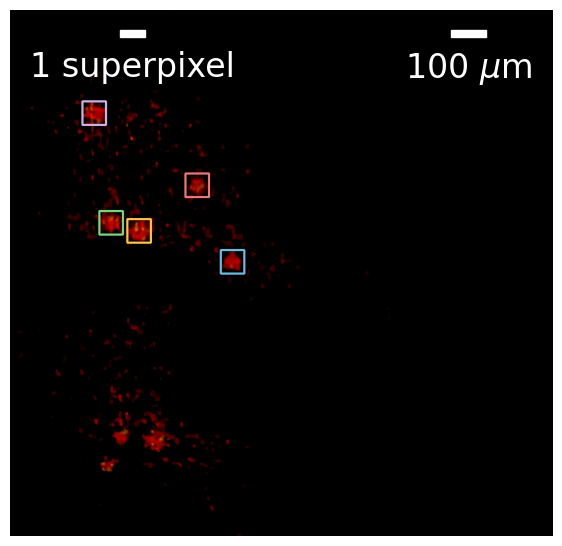

In [49]:
datafolder = '../Results/Stanford'
file = 'code1mrbles_10x_2meas.tiff_thr=6e-06_xytv=1e-06_lamtv=2e-06_kmax=2000_stepsize=0.1_downsample=2.npy'
skip = [0,1,2,3,4]

xk = np.load(os.path.join(datafolder, file))
xk = xk/jnp.max(xk)*jnp.sum(xk,0) # normalize the data to help with visualization. 
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)
bead_locations, recon_annotated = findbeadsinimage(false_color, beadsize=10, skip = skip, gray_thresh = 10)
# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(recon_annotated**0.4)
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebarum)
# Print the bead locations
for i, (cx, cy) in enumerate(bead_locations):
    print(f"Bead {i+1} - X: {cx}, Y: {cy}")


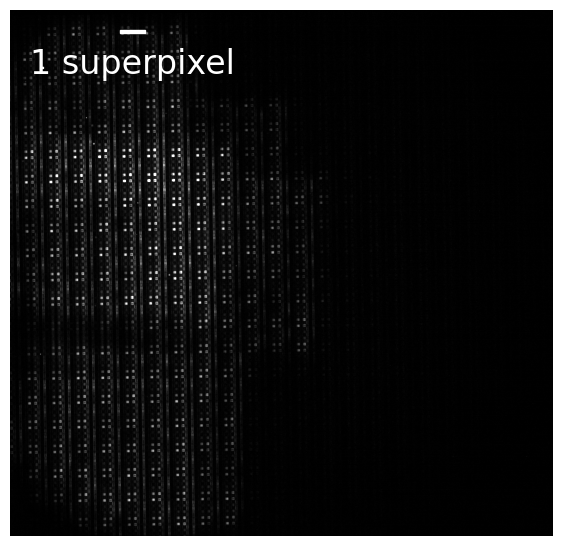

In [50]:
crop_indices = [420,1852,1350,2826] #top bottom left default: [320,1652,1350,2726]
datafolder = '/home/neerja/DATA/SDCData/2024-05-24/code1mrbles_10x_2'
meas_name = 'meas.tiff'
bg_name = 'bg.tiff'
bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement**1, cmap='gray')
# plt.colorbar()  
plt.clim([0,.2])
plt.axis('off')

scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size)
ax.add_artist(scalebar)


5
6
7
8
9


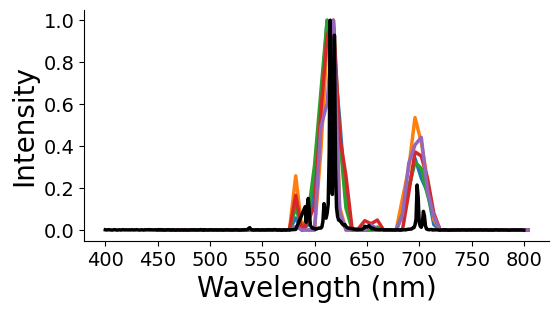

In [51]:
# plot the spectra
spectra = np.zeros((len(bead_locations), xk.shape[0]))
plt.figure(figsize=(6, 3))
skip = [0,1,2,3,4]
pix_avg = 1 # number of pixels to average over. 
for i, (cx, cy) in enumerate(bead_locations):
    if i not in skip: #skip 
        print(i)
        spectra[i,:] = np.mean(xk[:,cy-pix_avg:cy+pix_avg,cx-pix_avg:cx+pix_avg],(1,2))
        spectra[i,:] = spectra[i,:]/np.max(xk[:,cy,cx])
        spectra[i,:] = spectra[i,:]/np.max(spectra[i,:])
        plt.plot(wavelengths, spectra[i, :].T, linewidth=2.5)

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(wavelengths_gt, spectra_gt[:,0],'k',linewidth=2.5)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
# no ground truth taken. 

## Plot Sm

In [64]:
wvmin = 450
wvmax = 700
wvstep = 8
downsample_factor = 2
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)
objective = 10

mag_size = objective*9/39 # 4x followed by diffuser
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor # 2x2 downsampling
gt_pixel_size = 4.4 # um
gt_mag_size = objective*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um

Bead 1 - X: 189, Y: 503
Bead 2 - X: 219, Y: 472
Bead 3 - X: 429, Y: 318
Bead 4 - X: 165, Y: 302
Bead 5 - X: 463, Y: 246


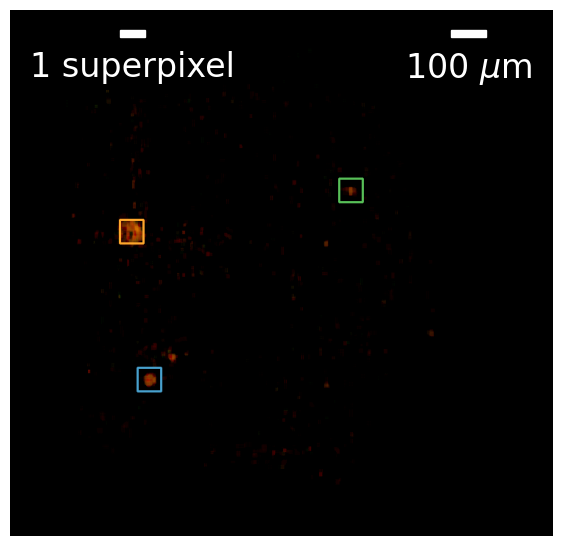

In [65]:
datafolder = '../Results/Stanford'
file = 'code2sm_10x_22nmFWHM_wvstep8_thr=6e-05_xytv=5e-06_lamtv=0_kmax=4000_stepsize=0.1_downsample=2.npy'
skip = [1,2]

xk = np.load(os.path.join(datafolder, file))
xk = xk/jnp.max(xk)*jnp.sum(xk,0) # normalize the data to help with visualization. 
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)
bead_locations, recon_annotated = findbeadsinimage(false_color, beadsize=10, skip = skip, gray_thresh = 10, label_bead = False)
# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(recon_annotated**0.6)
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebarum)
# Print the bead locations
for i, (cx, cy) in enumerate(bead_locations):
    print(f"Bead {i+1} - X: {cx}, Y: {cy}")


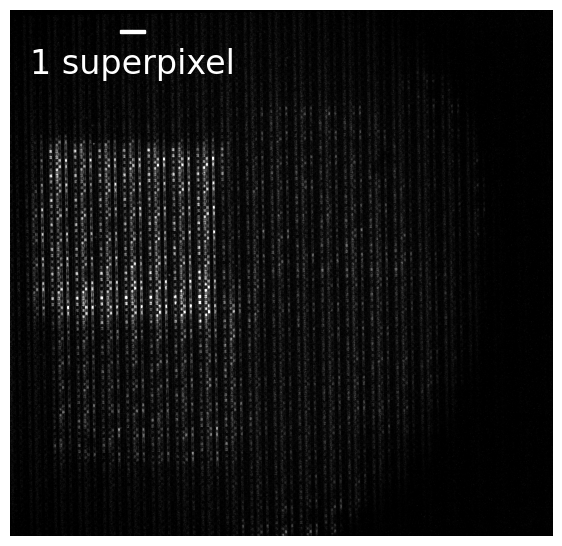

In [66]:
crop_indices = [420,1852,1350,2826] #top bottom left default: [320,1652,1350,2726]
datafolder = '/home/neerja/DATA/SDCData/2024-05-30/code2sm_10x_2'
meas_name = 'meas.tiff'
bg_name = 'bg.tiff'
bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement**1, cmap='gray')
# plt.colorbar()  
plt.clim([0,.3])
plt.axis('off')

scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size)
ax.add_artist(scalebar)


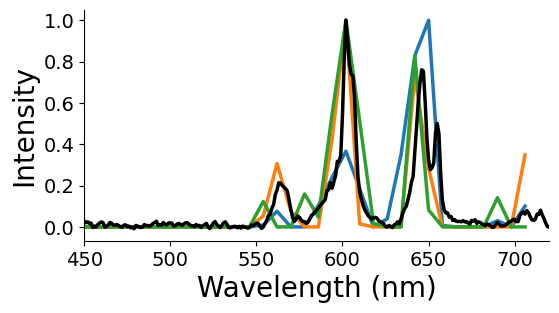

In [122]:
# plot the spectra
spectra = np.zeros((len(bead_locations), xk.shape[0]))
plt.figure(figsize=(6, 3))
skip = [1,2]
pix_avg = 1 # radius of pixels to average over. 
for i, (cx, cy) in enumerate(bead_locations):
    if i not in skip: #skip 
        spectra[i,:] = np.mean(xk[:,cy-pix_avg:cy+pix_avg,cx-pix_avg:cx+pix_avg],(1,2))
        spectra[i,:] = spectra[i,:]/np.max(xk[:,cy,cx])
        spectra[i,:] = spectra[i,:]/np.max(spectra[i,:])
        plt.plot(wavelengths, spectra[i, :].T, linewidth=2.5)

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#smooth the gt data with a moving average to get rid of noise
sm_gt_filt = np.convolve(spectra_gt[:,3], np.ones(3)/3, mode='same')
sm_gt_filt = sm_gt_filt/np.max(sm_gt_filt)
plt.plot(wavelengths_gt, sm_gt_filt,'k',linewidth=2.5)
plt.xlim([450,720])
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(2265.0, 500.0)

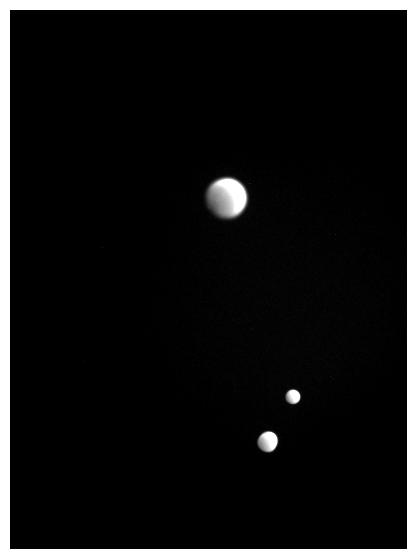

In [103]:
# draw groundtruth
#ACTION: CHANGE DATA FOLDER, SAMPLE FOLDER, BACKGROUND FOLDER TO FIND YOUR MEASUREMENT
gt_name = 'gt.png'

# load sample and background both located in datafolder
gt = sdc.importTiff(datafolder,gt_name)/2**bits
gt = gt/torch.max(gt)

import scipy.ndimage as ndimage

# Rotate the image without zero-padding
gt_rot = ndimage.rotate(gt, 130, reshape=True)
gt_rot = gt_rot/np.max(gt_rot)
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_rot[:,:,0],cmap='gray') # just plot one channel of the image
plt.axis('off')
# scalebar = drawscalebar(ax, 100,gt_pixel_size,mag = gt_mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
# ax.add_artist(scalebar)
# increase contrast
# plt.colorbar()
plt.clim([0.3,.7])
plt.xlim([500,1800])
plt.ylim([2265,500])

## Plot EuDySm ratio

In [143]:
wvmin = 450
wvmax = 700
wvstep = 8
downsample_factor = 2
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)
objective = 10

mag_size = objective*9/39 # 4x followed by diffuser
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor # 2x2 downsampling
gt_pixel_size = 4.4 # um
gt_mag_size = objective*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um

Bead 1 - X: 327, Y: 643
Bead 2 - X: 441, Y: 458
Bead 3 - X: 56, Y: 449
Bead 4 - X: 432, Y: 448
Bead 5 - X: 200, Y: 410
Bead 6 - X: 664, Y: 295
Bead 7 - X: 166, Y: 280
Bead 8 - X: 411, Y: 196
Bead 9 - X: 206, Y: 145


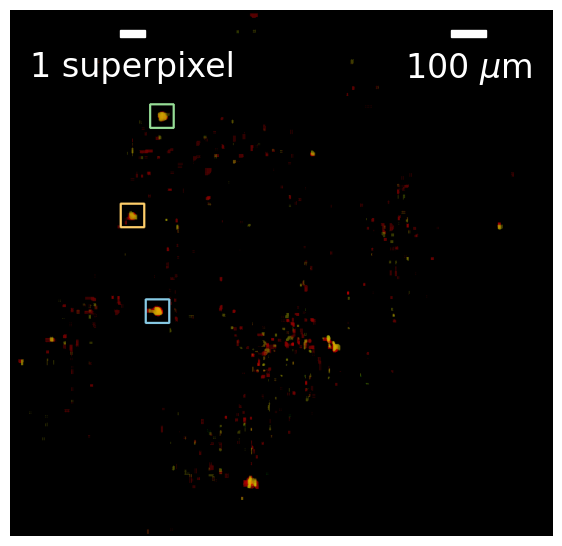

In [144]:
datafolder = '../Results/Stanford'
file = 'code8eusmdy_10x2nmFWHM_wvstep8_thr=6e-05_xytv=5e-06_lamtv=0_kmax=4000_stepsize=0.1_downsample=2.npy'
skip = [0,1,2,3,5,7,9]

xk = np.load(os.path.join(datafolder, file))
xk = xk/jnp.max(xk)*jnp.sum(xk,0) # normalize the data to help with visualization. 
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)
bead_locations, recon_annotated = findbeadsinimage(false_color, beadsize=10, skip = skip, gray_thresh = 20, label_bead = False)
# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(recon_annotated**0.3)
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebarum)
# Print the bead locations
for i, (cx, cy) in enumerate(bead_locations):
    print(f"Bead {i+1} - X: {cx}, Y: {cy}")


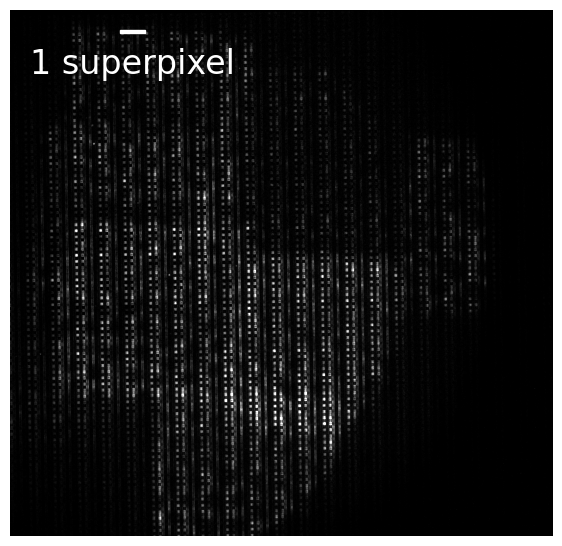

In [145]:
crop_indices = [420,1852,1350,2826] #top bottom left default: [320,1652,1350,2726]
datafolder = '/home/neerja/DATA/SDCData/2024-05-31/code8eusmdy_10x'
meas_name = 'meas.tiff'
bg_name = 'bg.tiff'
bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement**1, cmap='gray')
# plt.colorbar()  
plt.clim([0,.3])
plt.axis('off')

scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size)
ax.add_artist(scalebar)


4
6
8


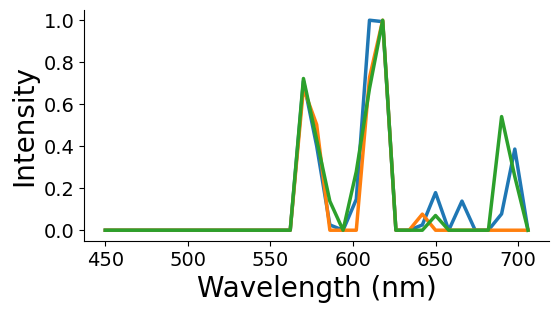

In [146]:
# plot the spectra
spectra = np.zeros((len(bead_locations), xk.shape[0]))
plt.figure(figsize=(6, 3))
skip = [0,1,2,3,5,7,9]
pix_avg = 1 # number of pixels to average over. 
for i, (cx, cy) in enumerate(bead_locations):
    if i not in skip: #skip 
        print(i)
        spectra[i,:] = np.mean(xk[:,cy-pix_avg:cy+pix_avg,cx-pix_avg:cx+pix_avg],(1,2))
        spectra[i,:] = spectra[i,:]/np.max(xk[:,cy,cx])
        spectra[i,:] = spectra[i,:]/np.max(spectra[i,:])
        plt.plot(wavelengths, spectra[i, :].T, linewidth=2.5)

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot(wavelengths_gt, spectra_gt[:,1],'k.',linewidth=2.5)
# use ratio of dyes to predict gt spectra. 

# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

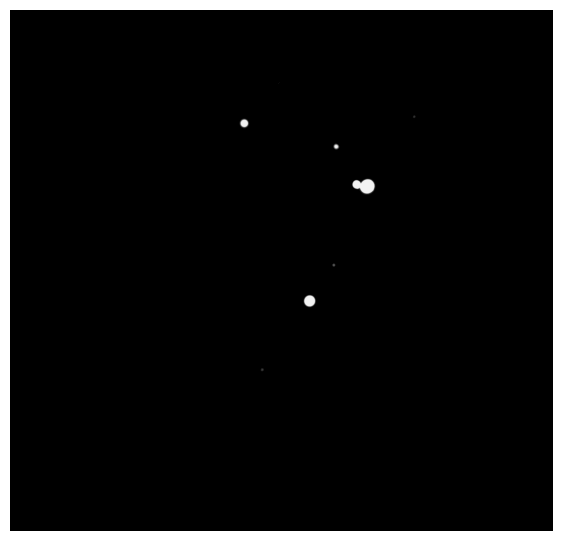

In [159]:
# draw groundtruth
#ACTION: CHANGE DATA FOLDER, SAMPLE FOLDER, BACKGROUND FOLDER TO FIND YOUR MEASUREMENT
gt_name = 'gt.png'

# load sample and background both located in datafolder
gt = sdc.importTiff(datafolder,gt_name)/2**bits
gt = gt/torch.max(gt)

import scipy.ndimage as ndimage

# Rotate the image without zero-padding
# flip the image
gt = torch.flip(gt, [1])
gt_rot = ndimage.rotate(gt, 40, reshape=True)
gt_rot = gt_rot/np.max(gt_rot)
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_rot[:,:,0],cmap='gray') # just plot one channel of the image
plt.axis('off')
# scalebar = drawscalebar(ax, 100,gt_pixel_size,mag = gt_mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
# ax.add_artist(scalebar)
# increase contrast
# plt.colorbar()
plt.clim([0.4,1])
# plt.xlim([500,1900])
# plt.ylim([2265,500])

## Plot Dy

In [123]:
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 2
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)
objective = 4

mag_size = objective*9/39 # 4x followed by diffuser
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor # 2x2 downsampling
gt_pixel_size = 4.4 # um
gt_mag_size = objective*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um

Bead 1 - X: 336, Y: 472
Bead 2 - X: 441, Y: 439
Bead 3 - X: 364, Y: 294
Bead 4 - X: 287, Y: 263
Bead 5 - X: 379, Y: 212


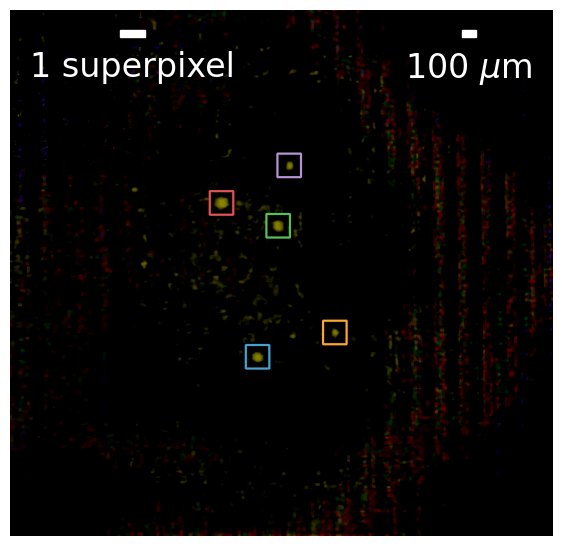

In [133]:
datafolder = '../Results/FOM2024'
file = 'mrbles_code3dymeas.tiff_thr=6e-06_xytv=1e-06_lamtv=2e-06_kmax=2000_stepsize=0.1_downsample=2.npy'
objective = 4

xk = np.load(os.path.join(datafolder, file))
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)
bead_locations, recon_annotated = findbeadsinimage(false_color, 30)

# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(recon_annotated**.6)
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebarum)
# Print the bead locations
for i, (cx, cy) in enumerate(bead_locations):
    print(f"Bead {i+1} - X: {cx}, Y: {cy}")

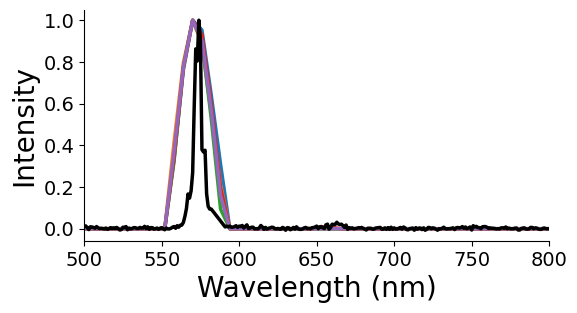

In [125]:
# plot the spectra
spectra = np.zeros((len(bead_locations), xk.shape[0]))
plt.figure(figsize=(6, 3))
for i, (cx, cy) in enumerate(bead_locations):
    spectra[i,:] = xk[:,cy,cx]/np.max(xk[:,cy,cx])
    plt.plot(wavelengths, spectra[i, :].T, color=colors[i], linewidth=2.5)

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(wavelengths_gt, spectra_gt[:,2],'k',linewidth=2.5)
# Turn off the box
plt.xlim([500,800])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

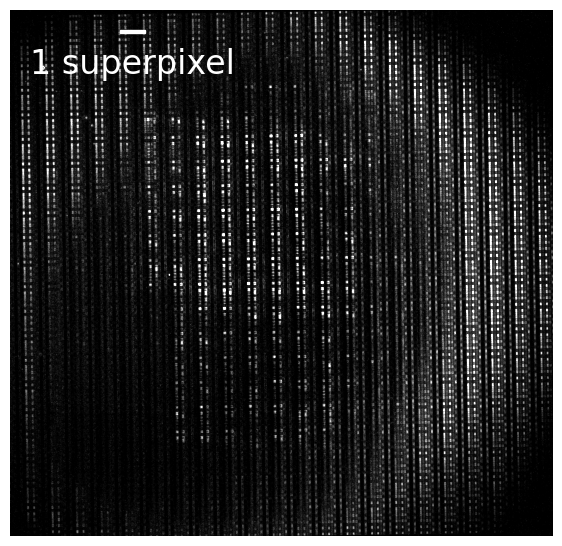

In [126]:
crop_indices = [420,1852,1350,2826] #top bottom left default: [320,1652,1350,2726]
datafolder = '/media/azuldata/neerja/2024-02-01/mrbles_code3dy'
meas_name = 'meas.tiff'
bg_name = 'bg.tiff'
bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement**1, cmap='gray')
# plt.colorbar()  
plt.clim([0,.2])
plt.axis('off')

scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size)
ax.add_artist(scalebar)


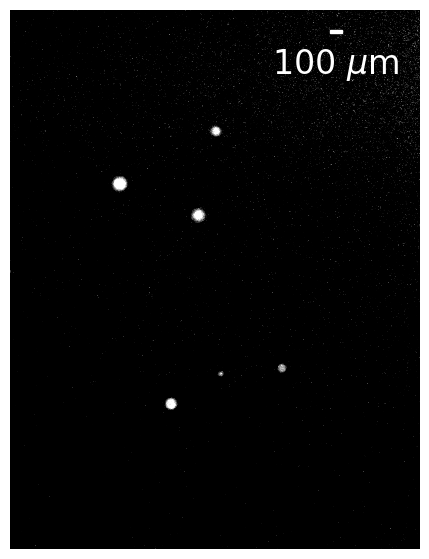

In [131]:
# draw groundtruth
#ACTION: CHANGE DATA FOLDER, SAMPLE FOLDER, BACKGROUND FOLDER TO FIND YOUR MEASUREMENT
gt_name = 'gt.tiff'

# load sample and background both located in datafolder
gt = sdc.importTiff(datafolder,gt_name)/2**bits
gt = gt/torch.max(gt)

import scipy.ndimage as ndimage

# Rotate the image without zero-padding
gt_rot = ndimage.rotate(gt, -90, reshape=True)

fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_rot,cmap='gray')
plt.axis('off')
# plt.colorbar()
plt.clim([0.2,.4])
scalebar = drawscalebar(ax, 100,gt_pixel_size,mag = gt_mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebar)

## Plot Eu - WallerLab data

In [161]:
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 2
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)
objective = 4

mag_size = objective*9/39 # 4x followed by diffuser
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor # 2x2 downsampling
gt_pixel_size = 4.4 # um
gt_mag_size = objective*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bead 1 - X: 452, Y: 632
Bead 2 - X: 359, Y: 486
Bead 3 - X: 94, Y: 411
Bead 4 - X: 310, Y: 222
Bead 5 - X: 391, Y: 213


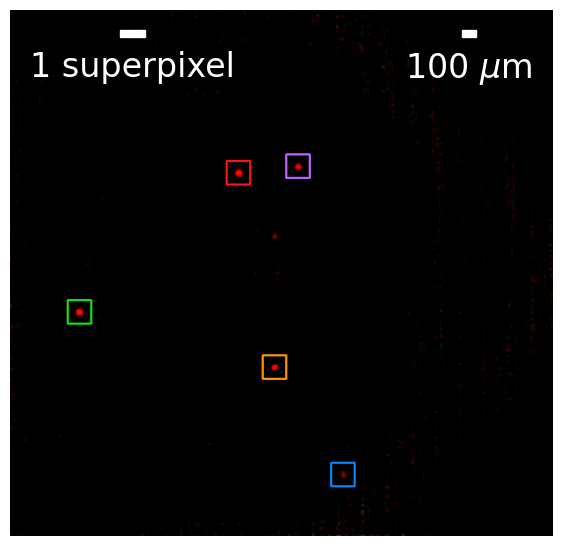

In [162]:
datafolder = '../Results/FOM2024'
file = 'mrbles_code1eumeas_20db.tiff_thr=6e-06_xytv=1e-06_lamtv=2e-06_kmax=2000_stepsize=0.1_downsample=2.npy'

xk = np.load(os.path.join(datafolder, file))
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)
bead_locations, recon_annotated = findbeadsinimage(false_color, 30)

# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(recon_annotated**1.8*2)
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebarum)
# Print the bead locations
for i, (cx, cy) in enumerate(bead_locations):
    print(f"Bead {i+1} - X: {cx}, Y: {cy}")

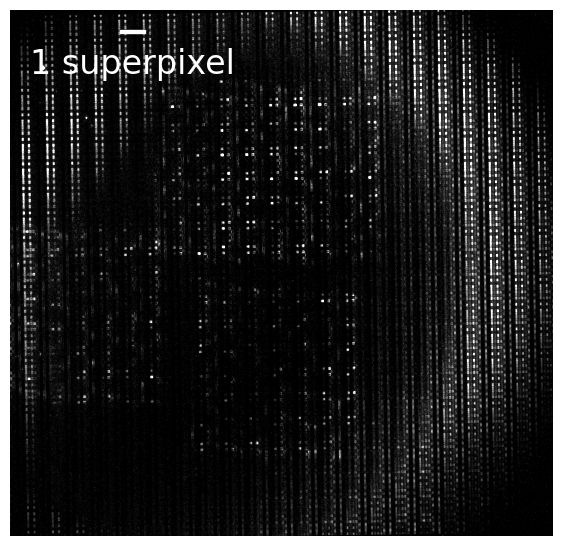

In [163]:
crop_indices = [420,1852,1350,2826] #top bottom left default: [320,1652,1350,2726]
datafolder = '/media/azuldata/neerja/2024-02-01/mrbles_code1eu'
meas_name = 'meas_20db.tiff'
bg_name = 'bg_20db.tiff'
bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement**1, cmap='gray')
# plt.colorbar()  
plt.clim([0,.05])
plt.axis('off')

scalebar = drawscalebar(ax, 160,2.4)
ax.add_artist(scalebar)

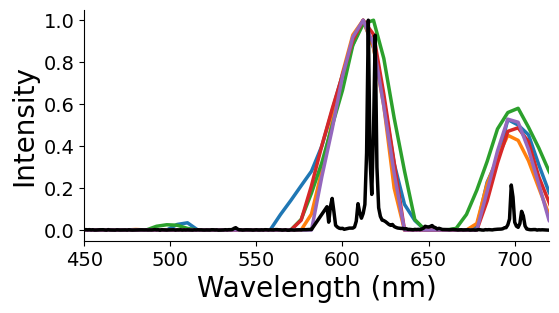

In [165]:
# plot the spectra
spectra = np.zeros((len(bead_locations), xk.shape[0]))
plt.figure(figsize=(6, 3))
skip = []
for i, (cx, cy) in enumerate(bead_locations):
    if i not in skip: #skip the first fake bead
        spectra[i,:] = xk[:,cy,cx]/np.max(xk[:,cy,cx])
        plt.plot(wavelengths, spectra[i, :].T, color=colors[i], linewidth=2.5)

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(wavelengths_gt, spectra_gt[:,0],'k',linewidth=2.5)
plt.xlim([450,720])
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)